<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/V5_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

In [3]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords
image_width = 1500
image_height = 200
pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from Layers import *
from HTREncoder import *
from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.view(batch_size, 1, image_width, image_height).to(device)

In [0]:

encoder = HTREncoder().to(device)

In [8]:
c = encoder(data)
c.shape

torch.Size([100, 64, 9, 11])

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=92, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        x = self.drop(x).squeeze()
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            self.attention_weights = self.attention(attention_inp)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:
      batch = test_set.make_batch()
      if batch is None:
        break

      orig_data, target = batch
      data = orig_data/255.0
      #data = data.view(batch_size, 1, image_width, image_height).to(device)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
      hidden = decoder.makeHidden().to(device)    

      loss = 0
      enc = encoder(data)
      #print(enc.shape)
      s = enc
      #print(s.shape)
      #s = s.flatten(start_dim=1).view(1, batch_size, -1)

      old_symbol[:, 0] = START

      for i in range(0, target.shape[1]):

        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = target[:, i]

        loss += criterion(dec, target[:, i])
      c_loss += loss.item()/(target.shape[1] + 0)
      test_loss += loss.item()/(target.shape[1] + 0)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
      
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
 
  discriminator_loss /= target.shape[1]
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

Training epoch 0...
Discr loss: 0.687833
  Batch: 30 Loss: 3.353029003496523
Discr loss: 0.693416
  Batch: 60 Loss: 3.3121138725583514
Discr loss: 0.104503
  Batch: 90 Loss: 3.5550190918281586
Discr loss: 0.734509
  Batch: 120 Loss: 3.028764160373224
Discr loss: 0.083728
  Batch: 150 Loss: 3.480778434314425
Discr loss: 0.240936
  Batch: 180 Loss: 3.2851628448849635
Discr loss: 0.067536
  Batch: 210 Loss: 3.5270621497038177
Discr loss: 0.357613
  Batch: 240 Loss: 3.3916969418904146
Discr loss: 0.087468
  Batch: 270 Loss: 3.3577100988418334
Discr loss: 0.242108
  Batch: 300 Loss: 3.433916411778284
Discr loss: 0.386928
  Batch: 330 Loss: 3.398988513568091
Discr loss: 0.791971
  Batch: 360 Loss: 3.570629440186516
Discr loss: 0.774096
  Batch: 390 Loss: 3.306737008927361
Discr loss: 0.637071
  Batch: 420 Loss: 3.246482871020282
Discr loss: 0.833348
  Batch: 450 Loss: 3.519806824285517
Discr loss: 0.803640
  Batch: 480 Loss: 3.59322454724993
Discr loss: 0.593207
  Batch: 510 Loss: 3.44499050

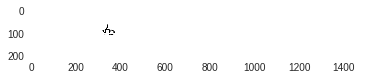

  'to' -> 'th<STOP>'


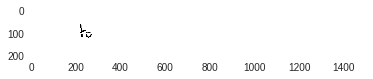

  'to' -> 'ah<STOP>'


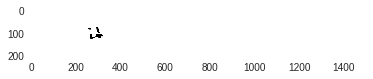

  'it' -> 'tnn'
  Batch: 20 Loss: 3.1303184832466973


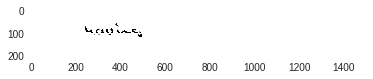

  'having' -> 'tenen<STOP><STOP>'


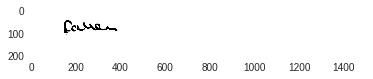

  'fallen' -> 'tan<STOP><STOP><STOP><STOP>'


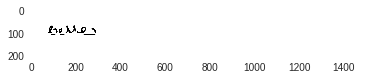

  'better' -> 'tat<STOP><STOP><STOP>n'
  Batch: 40 Loss: 2.8573811925025216


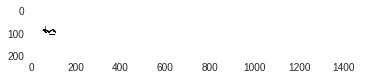

  'to' -> 'the'


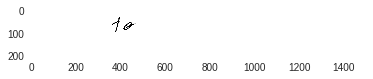

  'to' -> 'th<STOP>'


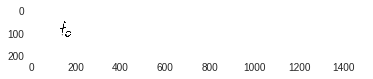

  'to' -> 'thr'
  Batch: 60 Loss: 2.8074791394718113
Test loss: 2.874604
Training epoch 1...
Discr loss: 0.200091
  Batch: 30 Loss: 3.5091068833214902
Discr loss: 0.099174
  Batch: 60 Loss: 3.6330112638927634
Discr loss: 0.148582
  Batch: 90 Loss: 3.309156652960197
Discr loss: 0.373113
  Batch: 120 Loss: 3.8738730610993803
Discr loss: 0.570558
  Batch: 150 Loss: 3.613888352358783
Discr loss: 0.501107
  Batch: 180 Loss: 3.4692060649205767
Discr loss: 0.244052
  Batch: 210 Loss: 3.1857254453941626
Discr loss: 0.383632
  Batch: 240 Loss: 3.2573273607284308
Discr loss: 0.539013
  Batch: 270 Loss: 3.1195880516243992
Discr loss: 0.205268
  Batch: 300 Loss: 3.347816670811365
Discr loss: 0.106741
  Batch: 330 Loss: 3.430773024432874
Discr loss: 0.526793
  Batch: 360 Loss: 3.348878799847194
Discr loss: 0.341924
  Batch: 390 Loss: 3.544894330287106
Discr loss: 0.056172
  Batch: 420 Loss: 3.2194248143201145
Discr loss: 0.066817
  Batch: 450 Loss: 3.3080993183075433
Discr loss: 0.194770
  Batch: 4

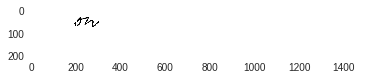

  'on' -> 'tn<STOP>'


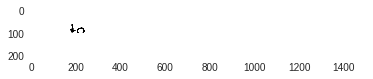

  'to' -> 'the'


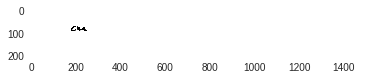

  'on' -> 'aft'
  Batch: 20 Loss: 3.1328401483051356


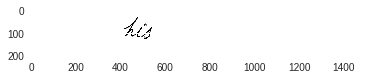

  'his' -> 'tenr'


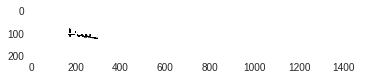

  'the' -> 'the<STOP>'


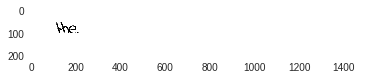

  'the' -> 'ahe<STOP>'
  Batch: 40 Loss: 2.6797333119029094


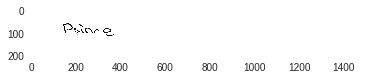

  'Prince' -> 'toen<STOP><STOP><STOP>'


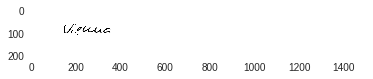

  'Vienna' -> 'ttd<STOP><STOP><STOP><STOP>'


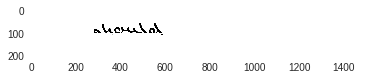

  'should' -> 'toe<STOP><STOP><STOP><STOP>'
  Batch: 60 Loss: 2.7116659981863838
Test loss: 2.794833
Training epoch 2...
Discr loss: 0.129641
  Batch: 30 Loss: 3.3481242070122366
Discr loss: 0.647812
  Batch: 60 Loss: 3.258866455138675
Discr loss: 0.099998
  Batch: 90 Loss: 3.206474952067017
Discr loss: 0.173502
  Batch: 120 Loss: 3.008509713505941
Discr loss: 0.230407
  Batch: 150 Loss: 2.8967046896616617
Discr loss: 0.220325
  Batch: 180 Loss: 3.11471229681893
Discr loss: 0.227500
  Batch: 210 Loss: 3.019198866748306
Discr loss: 0.204517
  Batch: 240 Loss: 3.2165460122830023
Discr loss: 0.232221
  Batch: 270 Loss: 3.5191385285059615
Discr loss: 0.525287
  Batch: 300 Loss: 3.460004828442973
Discr loss: 0.163244
  Batch: 330 Loss: 3.196449134135372
Discr loss: 0.544165
  Batch: 360 Loss: 3.159377736465011
Discr loss: 0.153934
  Batch: 390 Loss: 3.0299998982999687
Discr loss: 0.238938
  Batch: 420 Loss: 3.295278663029747
Discr loss: 0.315658
  Batch: 450 Loss: 3.0114671913782756
Discr l

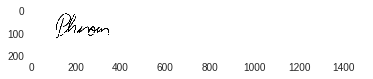

  'Phnom' -> 'tee<STOP><STOP><STOP>'


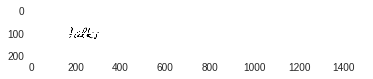

  'talks' -> 'ahn<STOP><STOP>s'


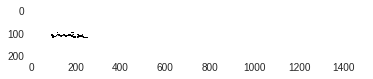

  'three' -> 'thee<STOP>e'
  Batch: 20 Loss: 2.9016711117350864


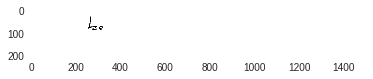

  'be' -> 'hae'


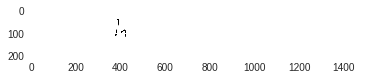

  'in' -> 'tne'


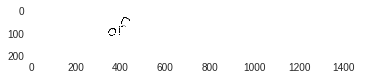

  'of' -> 'ont'
  Batch: 40 Loss: 2.7957079238740232


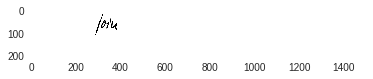

  'join' -> 'wsnn<STOP>'


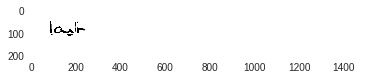

  'last' -> 'han<STOP><STOP>'


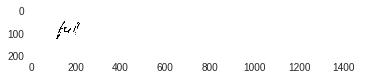

  'full' -> 'tene<STOP>'
  Batch: 60 Loss: 2.6636570102827895
Test loss: 2.741323
Training epoch 3...
Discr loss: 0.064864
  Batch: 30 Loss: 3.2305304061546525
Discr loss: 0.164350
  Batch: 60 Loss: 3.3084851250825102
Discr loss: 0.274067
  Batch: 90 Loss: 2.982544839823688
Discr loss: 0.473005
  Batch: 120 Loss: 3.258194369639038
Discr loss: 0.284006
  Batch: 150 Loss: 3.052560563970495
Discr loss: 0.563706
  Batch: 180 Loss: 3.2313387791063426
Discr loss: 0.678274
  Batch: 210 Loss: 3.0952892757345127
Discr loss: 0.671766
  Batch: 240 Loss: 3.0690849283006454
Discr loss: 0.502721
  Batch: 270 Loss: 3.086941948391142
Discr loss: 0.054164
  Batch: 300 Loss: 3.075671708142316
Discr loss: 0.067266
  Batch: 330 Loss: 3.0225674414256263
Discr loss: 0.321841
  Batch: 360 Loss: 3.148376315207708
Discr loss: 0.462045
  Batch: 390 Loss: 2.796819234348478
Discr loss: 0.189229
  Batch: 420 Loss: 2.989321792239234
Discr loss: 0.178524
  Batch: 450 Loss: 3.0555213892649093
Discr loss: 0.593812
  B

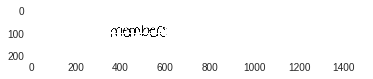

  'members' -> 'totee<STOP><STOP><STOP>'


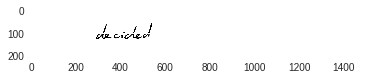

  'decided' -> 'tarin<STOP><STOP><STOP>'


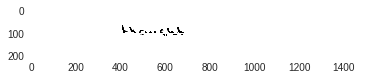

  'thought' -> 'thern<STOP><STOP><STOP>'
  Batch: 20 Loss: 3.1226193174861723


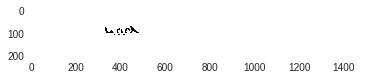

  'had' -> 'tene'


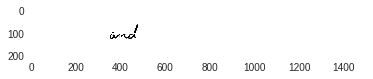

  'and' -> 'tn<STOP><STOP>'


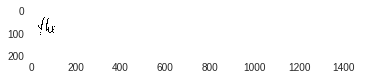

  'the' -> 'then'
  Batch: 40 Loss: 2.527784871260325


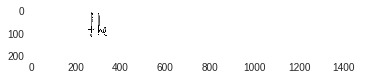

  'the' -> 'then'


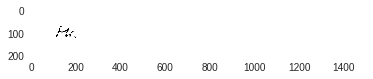

  'Mr.' -> 'toe<STOP>'


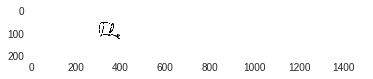

  'The' -> 'then'
  Batch: 60 Loss: 2.610958902041117
Test loss: 2.703234
Training epoch 4...
Discr loss: 0.214405
  Batch: 30 Loss: 3.120023848871705
Discr loss: 0.314627
  Batch: 60 Loss: 3.2260392834648255
Discr loss: 0.326639
  Batch: 90 Loss: 3.237572614452826
Discr loss: 0.223520
  Batch: 120 Loss: 2.9166020152682344
Discr loss: 0.545107
  Batch: 150 Loss: 3.086988389227125
Discr loss: 0.072860
  Batch: 180 Loss: 3.237755259508809
Discr loss: 0.196637
  Batch: 210 Loss: 3.021613111798725
Discr loss: 0.105604
  Batch: 240 Loss: 2.880183756994823
Discr loss: 0.274935
  Batch: 270 Loss: 3.0464664737257374
Discr loss: 0.331815
  Batch: 300 Loss: 2.8127233880663676
Discr loss: 0.240858
  Batch: 330 Loss: 2.8848555333273755
Discr loss: 0.339898
  Batch: 360 Loss: 2.9960041438460987
Discr loss: 0.254579
  Batch: 390 Loss: 2.8882198919064153
Discr loss: 0.177908
  Batch: 420 Loss: 3.1412262816151615
Discr loss: 0.317583
  Batch: 450 Loss: 2.75739366584354
Discr loss: 0.606501
  Batch: 48

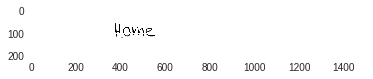

  'Home' -> 'te<STOP><STOP>n'


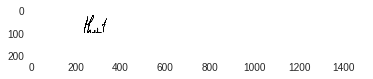

  'that' -> 'the<STOP>e'


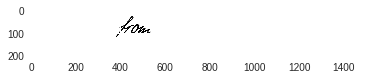

  'from' -> 'aee<STOP><STOP>'
  Batch: 20 Loss: 2.9038500978833155


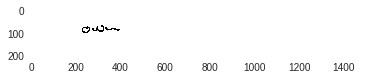

  'own' -> 'tf<STOP><STOP>'


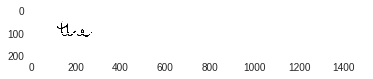

  'the' -> 'ahe<STOP>'


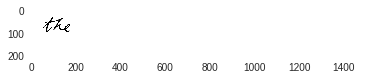

  'the' -> 'the<STOP>'
  Batch: 40 Loss: 2.9407761846648315
Test loss: 2.747387
Training epoch 5...
Discr loss: 0.280213
  Batch: 30 Loss: 3.117215832856597
Discr loss: 0.063134
  Batch: 60 Loss: 3.029344657716296
Discr loss: 0.311073
  Batch: 90 Loss: 2.9308598051121626
Discr loss: 0.226706
  Batch: 120 Loss: 3.0428776359305805
Discr loss: 0.172896
  Batch: 150 Loss: 2.9582586490287985
Discr loss: 0.257024
  Batch: 180 Loss: 2.864341467221578
Discr loss: 0.270316
  Batch: 210 Loss: 2.774026646387009
Discr loss: 0.798744
  Batch: 240 Loss: 2.9949497275882297
Discr loss: 0.175176
  Batch: 270 Loss: 2.824122981646704
Discr loss: 0.541224
  Batch: 300 Loss: 3.1356069723260465
Discr loss: 0.747139
  Batch: 330 Loss: 3.010071826763254
Discr loss: 0.389109
  Batch: 360 Loss: 2.8672652983791616
Discr loss: 0.537465
  Batch: 390 Loss: 2.9943692908968247
Discr loss: 0.161983
  Batch: 420 Loss: 2.9558213710784913
Discr loss: 0.245268
  Batch: 450 Loss: 2.758908225014096
Discr loss: 0.225842
  Ba

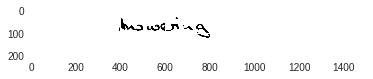

  'Answering' -> 'tn<STOP><STOP><STOP><STOP><STOP>n<STOP><START>'


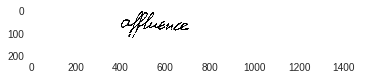

  'affluence' -> 'tn<STOP><STOP>e<STOP><STOP><STOP><STOP><START>'


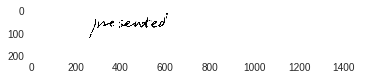

  'presented' -> 'tee<STOP><STOP><STOP><STOP><STOP><STOP><START>'
  Batch: 20 Loss: 2.9093247973729692


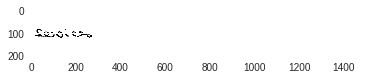

  'Service' -> 'ao<STOP>eenhn'


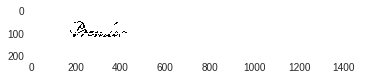

  'Premier' -> 'toe<STOP><STOP>s<STOP><STOP>'


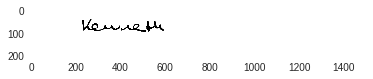

  'Kenneth' -> 'to<STOP><STOP><STOP><STOP><STOP><STOP>'
  Batch: 40 Loss: 2.7119029546919324


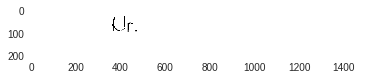

  'Mr.' -> 'ooed'


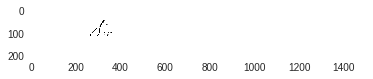

  'Sir' -> 'thn<STOP>'


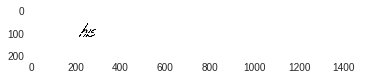

  'his' -> 'tet<STOP>'
  Batch: 60 Loss: 2.534160737991333
Test loss: 2.673898
Training epoch 6...
Discr loss: 0.072212
  Batch: 30 Loss: 3.13624052168831
Discr loss: 0.147882
  Batch: 60 Loss: 2.9894525437884862
Discr loss: 0.204017
  Batch: 90 Loss: 2.893559358384874
Discr loss: 0.143872
  Batch: 120 Loss: 2.804988099506923
Discr loss: 0.266904
  Batch: 150 Loss: 2.9109973068085933
Discr loss: 0.585871
  Batch: 180 Loss: 2.830953108747169
Discr loss: 0.329575
  Batch: 210 Loss: 2.8099576894063794
Discr loss: 0.661275
  Batch: 240 Loss: 2.8728500118962046
Discr loss: 0.063784
  Batch: 270 Loss: 2.858658484781861
Discr loss: 0.238347
  Batch: 300 Loss: 2.782362908862886
Discr loss: 0.477519
  Batch: 330 Loss: 2.933351068017344
Discr loss: 0.237022
  Batch: 360 Loss: 2.7304648789905364
Discr loss: 0.167405
  Batch: 390 Loss: 2.8496103077843076
Discr loss: 0.352628
  Batch: 420 Loss: 2.7923672943266613
Discr loss: 0.214903
  Batch: 450 Loss: 2.8169417950463673
Discr loss: 0.660801
  Batc

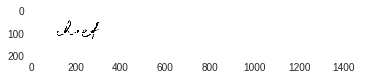

  'chief' -> 'aoatd<STOP>'


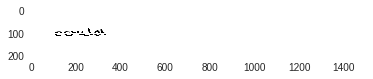

  'could' -> 'thrt<STOP>s'


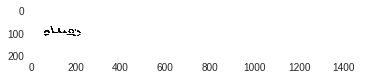

  'other' -> 'hn<STOP>e<STOP><STOP>'
  Batch: 20 Loss: 2.8422530741161767


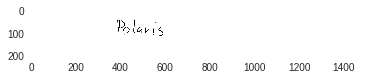

  'Polaris' -> 'tarenee<STOP>'


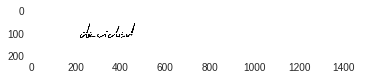

  'decided' -> 'toatne<STOP><STOP>'


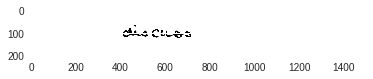

  'discuss' -> 'tot<STOP>e<STOP><STOP><STOP>'
  Batch: 40 Loss: 2.6744544077298


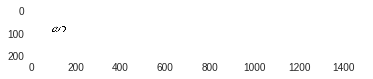

  'an' -> 'tn<STOP>'


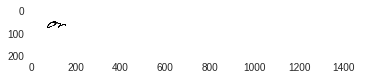

  'on' -> 'tfe'


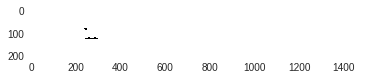

  'in' -> 'ane'
  Batch: 60 Loss: 2.319115817319779
Test loss: 2.566898
Training epoch 7...
Discr loss: 0.236500
  Batch: 30 Loss: 2.889541579882304
Discr loss: 0.223061
  Batch: 60 Loss: 3.027450366398645
Discr loss: 0.173759
  Batch: 90 Loss: 2.8301116501338894
Discr loss: 0.650035
  Batch: 120 Loss: 2.885868529567012
Discr loss: 0.573743
  Batch: 150 Loss: 2.83341101464771
Discr loss: 0.172671
  Batch: 180 Loss: 2.7800250533775053
Discr loss: 0.265052
  Batch: 210 Loss: 2.893159556010412
Discr loss: 0.332105
  Batch: 240 Loss: 2.9448044481479303
Discr loss: 0.057236
  Batch: 270 Loss: 2.9438596185048427
Discr loss: 0.811475
  Batch: 300 Loss: 2.899981816231258
Discr loss: 0.171294
  Batch: 330 Loss: 2.6249608318893993
Discr loss: 0.283701
  Batch: 360 Loss: 2.7003421153971763
Discr loss: 0.244677
  Batch: 390 Loss: 2.690546735354832
Discr loss: 0.277878
  Batch: 420 Loss: 2.6975317231435625
Discr loss: 0.210972
  Batch: 450 Loss: 3.091260839341179
Discr loss: 0.175957
  Batch: 480 L

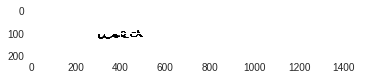

  'used' -> 'on<STOP><STOP>e'


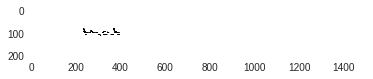

  'that' -> 'ahete'


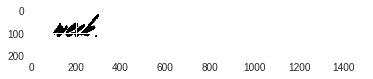

  'week' -> 'ae<STOP><STOP>e'
  Batch: 20 Loss: 2.7804694734679325


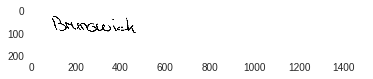

  'Brunswick' -> 'toe<STOP><STOP><STOP><STOP>nh<START>'


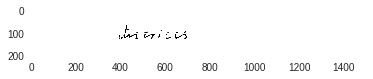

  'districts' -> 'aen<STOP><STOP>ene<STOP><START>'


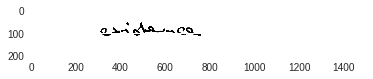

  'existence' -> 'auen<STOP><STOP><STOP><STOP><STOP><START>'
  Batch: 40 Loss: 2.79224099268989


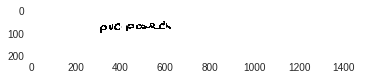

  'proposed' -> 'taer<STOP><STOP><STOP><STOP>h'


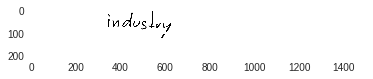

  'industry' -> 'tn<STOP><STOP><STOP><STOP><STOP><STOP><STOP>'


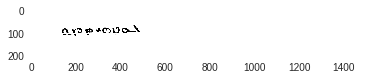

  'approval' -> 'h<STOP><STOP>eeuen<STOP>'
  Batch: 60 Loss: 2.6084407655398048
Test loss: 2.667464
Training epoch 8...
Discr loss: 0.034979
  Batch: 30 Loss: 3.0251535198675885
Discr loss: 0.055991
  Batch: 60 Loss: 3.0364178596980986
Discr loss: 0.240657
  Batch: 90 Loss: 2.8523210302484103
Discr loss: 0.149890
  Batch: 120 Loss: 2.908253876948483
Discr loss: 0.067423
  Batch: 150 Loss: 2.931213309701788
Discr loss: 0.059811
  Batch: 180 Loss: 2.757008413814363
Discr loss: 0.463219
  Batch: 210 Loss: 2.8467406786308085
Discr loss: 0.051294
  Batch: 240 Loss: 2.82379943327929
Discr loss: 0.216434
  Batch: 270 Loss: 2.716345470569751
Discr loss: 0.077910
  Batch: 300 Loss: 2.7598101284894994
Discr loss: 0.153538
  Batch: 330 Loss: 2.9048914383075854
Discr loss: 0.279014
  Batch: 360 Loss: 2.637681065741039
Discr loss: 0.789407
  Batch: 390 Loss: 2.7348947286353544
Discr loss: 0.084129
  Batch: 420 Loss: 2.7766531281244187
Discr loss: 0.168239
  Batch: 450 Loss: 2.747491182221306
Discr 

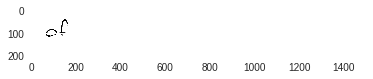

  'of' -> 'tnr'


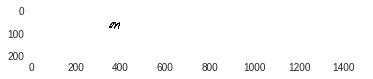

  'on' -> 'tfe'


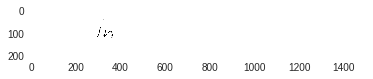

  'in' -> 'an<STOP>'
  Batch: 20 Loss: 2.712146071025304


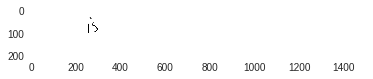

  'is' -> 'tn<STOP>'


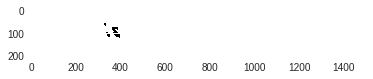

  'is' -> 'hnr'


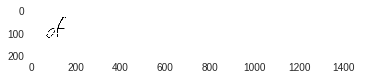

  'of' -> 'tfs'
  Batch: 40 Loss: 2.750361444306752


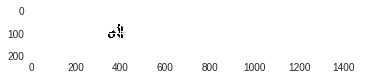

  'of' -> 'tfs'


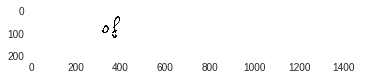

  'of' -> 'tfe'


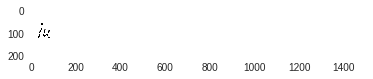

  'in' -> 'tne'
  Batch: 60 Loss: 2.4421931205855474
Test loss: 2.591492
Training epoch 9...
Discr loss: 0.060097
  Batch: 30 Loss: 2.8131102943420414
Discr loss: 0.076738
  Batch: 60 Loss: 2.858752051434189
Discr loss: 0.161475
  Batch: 90 Loss: 2.8163258402688163
Discr loss: 0.520968
  Batch: 120 Loss: 3.069539751375794
Discr loss: 0.149858
  Batch: 150 Loss: 2.9438105519612634
Discr loss: 0.519249
  Batch: 180 Loss: 2.747565609790661
Discr loss: 0.224444
  Batch: 210 Loss: 2.8877665265401204
Discr loss: 0.201196
  Batch: 240 Loss: 2.719682507943855
Discr loss: 0.200100
  Batch: 270 Loss: 2.724766124871673
Discr loss: 0.212578
  Batch: 300 Loss: 2.908938192513885
Discr loss: 0.269246
  Batch: 330 Loss: 2.7178936436315064
Discr loss: 0.033947
  Batch: 360 Loss: 2.8492555497436927
Discr loss: 0.594404
  Batch: 390 Loss: 2.788385192275678
Discr loss: 0.177988
  Batch: 420 Loss: 2.7380281006343785
Discr loss: 0.258958
  Batch: 450 Loss: 2.783117300972106
Discr loss: 0.339181
  Batch: 480

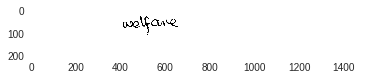

  'welfare' -> 'tar<STOP><STOP>re<STOP>'


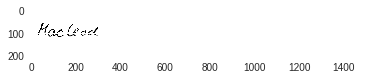

  'Macleod' -> 'fote<STOP><STOP>r<STOP>'


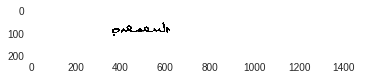

  'present' -> 'toer<STOP><STOP><STOP><STOP>'
  Batch: 20 Loss: 2.7373095363283917


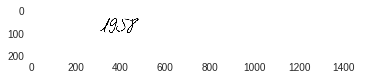

  '1958' -> 'tei<STOP><STOP>'


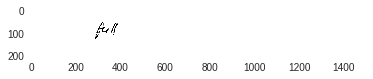

  'full' -> 'teted'


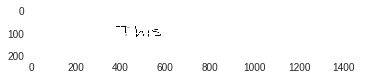

  'This' -> 'thes<STOP>'
  Batch: 40 Loss: 2.703342892101833


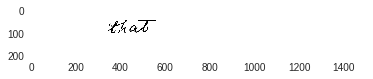

  'that' -> 'thet<STOP>'


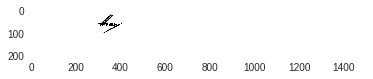

  'they' -> 'the<STOP>n'


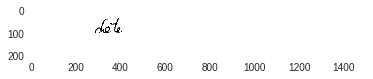

  'date' -> 'tot<STOP><STOP>'
  Batch: 60 Loss: 2.465087295638191
Test loss: 2.592046
Training epoch 10...
Discr loss: 0.104123
  Batch: 30 Loss: 2.7881063252403617
Discr loss: 0.076563
  Batch: 60 Loss: 2.7754864998216977
Discr loss: 0.269981
  Batch: 90 Loss: 2.81852358636402
Discr loss: 0.353571
  Batch: 120 Loss: 2.8085409877918384
Discr loss: 0.683257
  Batch: 150 Loss: 2.8417174031242496
Discr loss: 0.487915
  Batch: 180 Loss: 2.751064921485053
Discr loss: 0.185881
  Batch: 210 Loss: 2.692623002844513
Discr loss: 0.303182
  Batch: 240 Loss: 2.7131440624105867
Discr loss: 0.609972
  Batch: 270 Loss: 2.934748832737958
Discr loss: 0.094845
  Batch: 300 Loss: 2.749632951418559
Discr loss: 0.286728
  Batch: 330 Loss: 2.7127714646051806
Discr loss: 0.242685
  Batch: 360 Loss: 2.9449037974221364
Discr loss: 0.118900
  Batch: 390 Loss: 2.741981728190467
Discr loss: 0.251191
  Batch: 420 Loss: 2.921525486840143
Discr loss: 0.251007
  Batch: 450 Loss: 2.717244034242378
Discr loss: 0.109843

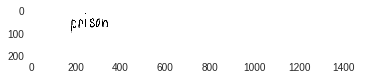

  'prison' -> 'toeee<STOP>l'


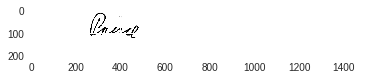

  'Prince' -> 'teet<STOP><STOP>n'


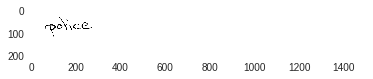

  'police' -> 'ter<STOP><STOP>t<STOP>'
  Batch: 20 Loss: 2.891234877071683


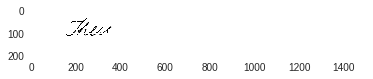

  'There' -> 'the<STOP><STOP>t'


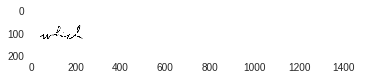

  'which' -> 'theshn'


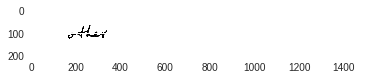

  'other' -> 'tfhe<STOP><STOP>'
  Batch: 40 Loss: 2.5141070331089077


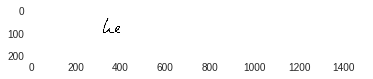

  'he' -> 'aae'


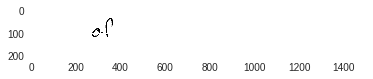

  'of' -> 'tfe'


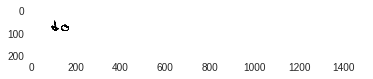

  'to' -> 'thd'
  Batch: 60 Loss: 2.411134714739663
Test loss: 2.558090
Training epoch 11...
Discr loss: 0.302532
  Batch: 30 Loss: 2.9566057551600937
Discr loss: 0.046026
  Batch: 60 Loss: 2.7391808089251244
Discr loss: 0.045057
  Batch: 90 Loss: 2.7907181280126014
Discr loss: 0.176367
  Batch: 120 Loss: 2.6115425644223653
Discr loss: 0.305567
  Batch: 150 Loss: 2.715022533381427
Discr loss: 0.761818
  Batch: 180 Loss: 2.7167813544046306
Discr loss: 0.653299
  Batch: 210 Loss: 2.8551492361038453
Discr loss: 0.696272
  Batch: 240 Loss: 3.0269110784833395
Discr loss: 0.299927
  Batch: 270 Loss: 2.6188196500142413
Discr loss: 0.203328
  Batch: 300 Loss: 2.64116638266851
Discr loss: 0.329919
  Batch: 330 Loss: 2.809971551516699
Discr loss: 0.179909
  Batch: 360 Loss: 2.7133392069327136
Discr loss: 0.559696
  Batch: 390 Loss: 2.7546467495721485
Discr loss: 0.166583
  Batch: 420 Loss: 2.825264698891412
Discr loss: 0.225209
  Batch: 450 Loss: 2.966316141527166
Discr loss: 0.248536
  Batch: 4

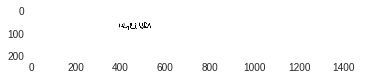

  'reserves' -> 'ae<STOP><STOP><STOP><STOP>e<STOP><STOP>'


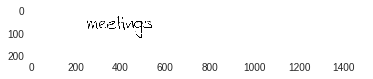

  'meetings' -> 'tern<STOP>ng<STOP><STOP>'


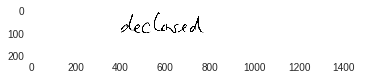

  'declared' -> 'to<STOP>he<STOP><STOP><STOP>d'
  Batch: 20 Loss: 2.825232490963406


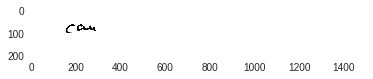

  'can' -> 'tos<STOP>'


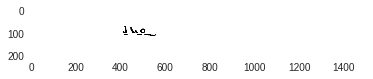

  'the' -> 'toeh'


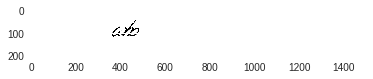

  'who' -> 'tae<STOP>'
  Batch: 40 Loss: 2.4924555646048647


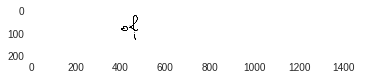

  'of' -> 'af<STOP>'


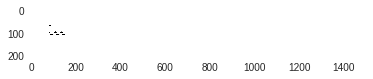

  'in' -> 'tne'


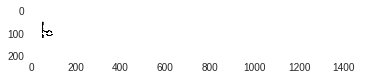

  'to' -> 'the'
  Batch: 60 Loss: 2.405039815675645
Test loss: 2.530858
Training epoch 12...
Discr loss: 0.222473
  Batch: 30 Loss: 2.7503225532410633


In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random

def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 30
  
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  discr_applied = 0
  
  while True:
    batch = train_set.make_batch()
    if batch is None:
      break
    
    orig_data, target = batch
    data = orig_data/255.0
    #data = data.view(batch_size, 1, image_width, image_height).to(device)
    data = data.unsqueeze(1).to(device)
    target = target.to(device)


    encoder.zero_grad()
    decoder.zero_grad()

    
    enc = encoder(data)
    #print(enc.shape)
    s = enc
    #s = enc.permute(1, 0, 2)
    #s = s.squeeze(0)
    #print(s.shape)
    #print(s.shape)
    #s = s.flatten(start_dim=1).view(1, batch_size, -1)
    #s = s.flatten(start_dim=1).squeeze(0)
    s = s.unsqueeze(0)
    #print(s.shape)
    
    discr_loss = 1
    if True:#target.shape[1] > 1:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      #print(dl)
      dl.backward()
      discriminator_optimizer.step()
   

      #     use_teacher_forcing = True if random() < teacher_forcing_ratio else False
      # #    recognition_result, loss, discriminator_loss = apply_discriminator(s, target, use_teacher_forcing, True, batch_zeros)
      #     recognition_result, loss = apply_decoder(s, target, use_teacher_forcing)
    batch_loss = None  
    if discr_loss < 0.3:
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      discr_applied += 1
      #print("Apply descr...")
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()

      
      
    c_loss += batch_loss/(target.shape[1] + 0)
    train_loss += batch_loss/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1] + 1]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)

for i in range(0, 100):
  max_size = 9
  train(i, max_size)
  test(max_size)

In [0]:
test(9)